In [18]:
!pip install plotly

In [1]:
!pip install fairlearn shap matplotlib seaborn scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference

In [4]:
# 📌 Upload your dataset file from your computer
from google.colab import files
uploaded = files.upload()

# 📌 Read the uploaded CSV (replace 'yourfile.csv' with actual filename)
import pandas as pd

df = pd.read_csv(next(iter(uploaded)))  # Automatically grabs the uploaded file
df.head()

Saving adult.csv to adult.csv


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
#data cleaning
df = df.dropna()

# Convert target column to binary (modify label if needed)
df['income'] = df['income'].apply(lambda x: 1 if str(x).strip() == '>50K' else 0)

# Encode categorical features
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.astype(str))
df = pd.get_dummies(df, drop_first=True)

In [6]:
#train-test split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

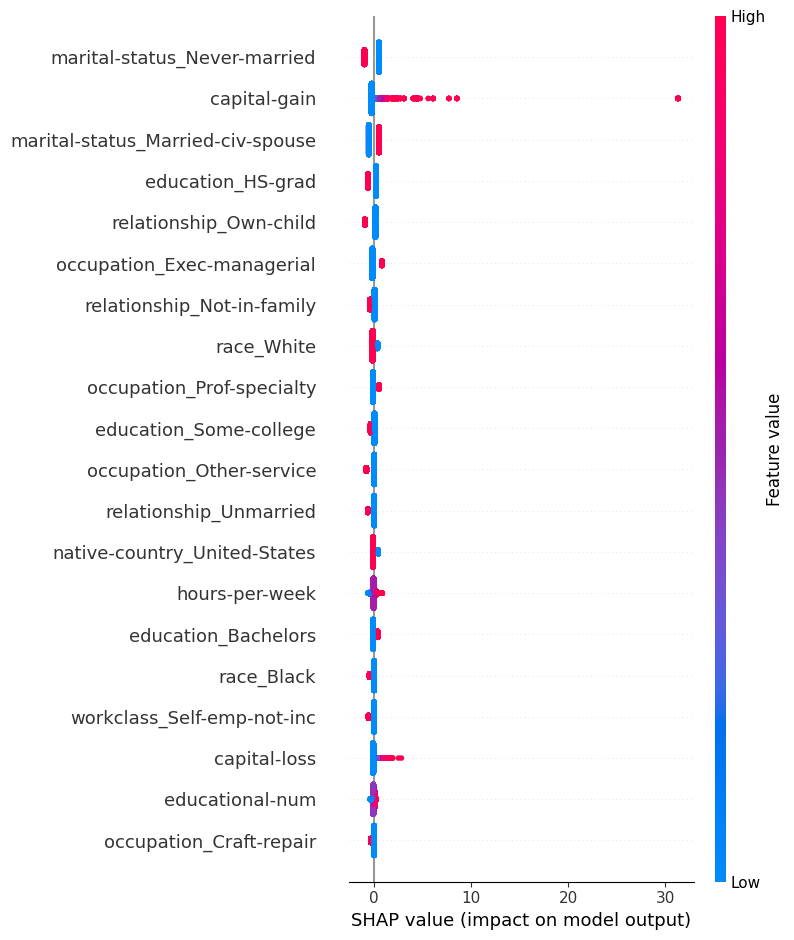

In [10]:
#SHAP Explainability
import shap
import numpy as np

explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

# Extract the SHAP values from the Explanation object and convert to float64
shap_values_array = np.array(shap_values.values, dtype=np.float64)

shap.summary_plot(shap_values_array, X_test)

In [14]:
#fairness audit
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference

# Use a sensitive attribute from your dataset — e.g., 'race_Black'
sensitive_feature = X_test.get('race_Black', pd.Series([0]*len(X_test)))  # Modify if using different attribute

mf = MetricFrame(metrics={"selection_rate": selection_rate},
                 y_true=y_test,
                 y_pred=model.predict(X_test),
                 sensitive_features=sensitive_feature)

print("📊 Selection Rates by Group:")
print(mf.by_group)

dp_diff = demographic_parity_difference(y_true=y_test, y_pred=model.predict(X_test), sensitive_features=sensitive_feature)
eo_diff = equalized_odds_difference(y_true=y_test, y_pred=model.predict(X_test), sensitive_features=sensitive_feature)


print(f"\n📉 Demographic Parity Difference: {dp_diff:.3f}")
print(f"📉 Equalized Odds Difference: {eo_diff:.3f}")

📊 Selection Rates by Group:
            selection_rate
race_Black                
False             0.199864
True              0.085744

📉 Demographic Parity Difference: 0.114
📉 Equalized Odds Difference: 0.075



📋 Ethics Scorecard:
Bias Score: 90.54, Explainability: 50, Data Quality: 70
✅ Final Ethics Score: 72.22 / 100
🚦 Ethics Rating: 🟡


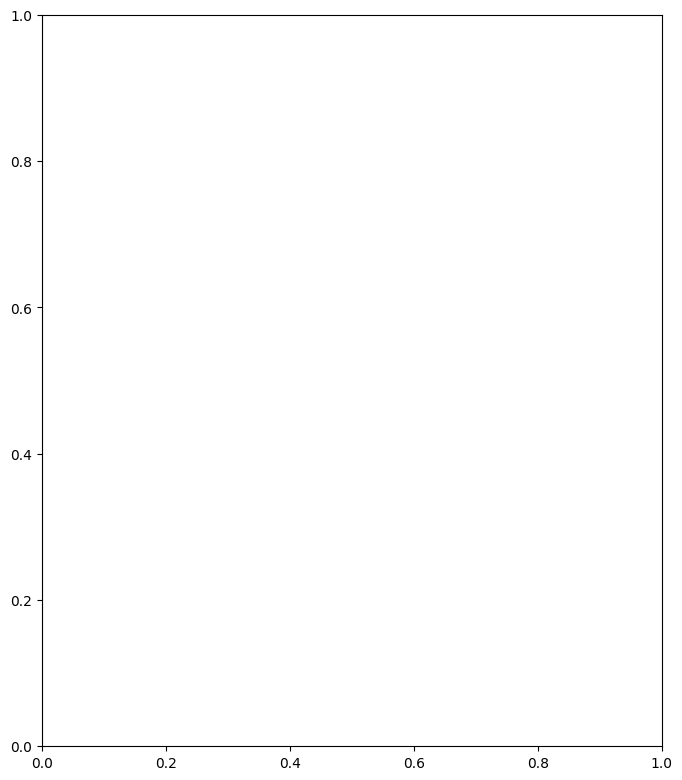

In [15]:
#ethics scorecard
# Bias Component
bias_score = (1 - abs(dp_diff)) * 50 + (1 - abs(eo_diff)) * 50

# Explainability Score
try:
    shap.summary_plot(shap_values, X_test)
    explain_score = 100
except:
    explain_score = 50

# Data Representation Score
black_ratio = sensitive_feature.mean()
data_score = 100 if black_ratio > 0.1 else 70

# Final Composite Score
ethics_score = (bias_score * 0.4) + (explain_score * 0.3) + (data_score * 0.3)

print(f"\n📋 Ethics Scorecard:\nBias Score: {bias_score:.2f}, Explainability: {explain_score}, Data Quality: {data_score}")
print(f"✅ Final Ethics Score: {ethics_score:.2f} / 100")

# Rating Indicator
color = "🟢" if ethics_score > 85 else "🟡" if ethics_score > 70 else "🔴"
print(f"🚦 Ethics Rating: {color}")

In [17]:
#policy complaience checklist
policy_checklist = {
    "Fairness Assessed": abs(dp_diff) < 0.1 and abs(eo_diff) < 0.1,
    "Explainability Verified": explain_score >= 80,
    "Sensitive Attributes Monitored": 'race_Black' in X.columns,
    "User Consent & Data Source Validated": True,
    "Reproducibility Ensured (Colab + Git)": True
}

print("\n📜 Policy Compliance Checklist:")
for item, status in policy_checklist.items():
    icon = "✅" if status else "⚠️"
    print(f"{icon} {item}")


📜 Policy Compliance Checklist:
⚠️ Fairness Assessed
⚠️ Explainability Verified
✅ Sensitive Attributes Monitored
✅ User Consent & Data Source Validated
✅ Reproducibility Ensured (Colab + Git)


In [19]:
#gauge
import plotly.graph_objects as go

# Create gauge chart
fig = go.Figure(go.Indicator(
    mode = "gauge+number",
    value = ethics_score,  # use your computed score here
    title = {'text': "ConscienceAI Ethics Score", 'font': {'size': 20}},
    gauge = {
        'axis': {'range': [0, 100], 'tickwidth': 2, 'tickcolor': "black"},
        'bar': {'color': "darkblue"},
        'steps': [
            {'range': [0, 70], 'color': "red"},
            {'range': [70, 85], 'color': "gold"},
            {'range': [85, 100], 'color': "green"}
        ],
        'threshold': {
            'line': {'color': "black", 'width': 4},
            'thickness': 0.75,
            'value': ethics_score
        }
    }
))

# Show chart in Colab
fig.show()

<class 'shap._explanation.Explanation'>


AttributeError: 'Explanation' object has no attribute 'dtype'